#Azure Agent for OpenAPI Integration ( YFINANCE )



Prerequisites

1. Create account in Rapid API and get the api key
2. Create openAPI spec json for Rapid API Yahoo finance api
3. Add API Key to Azure AI Project's Custom Key Connection [Navigate to your Azure AI Project, go to Management Center, select Custom Key, and securely add your API key as a secret.]


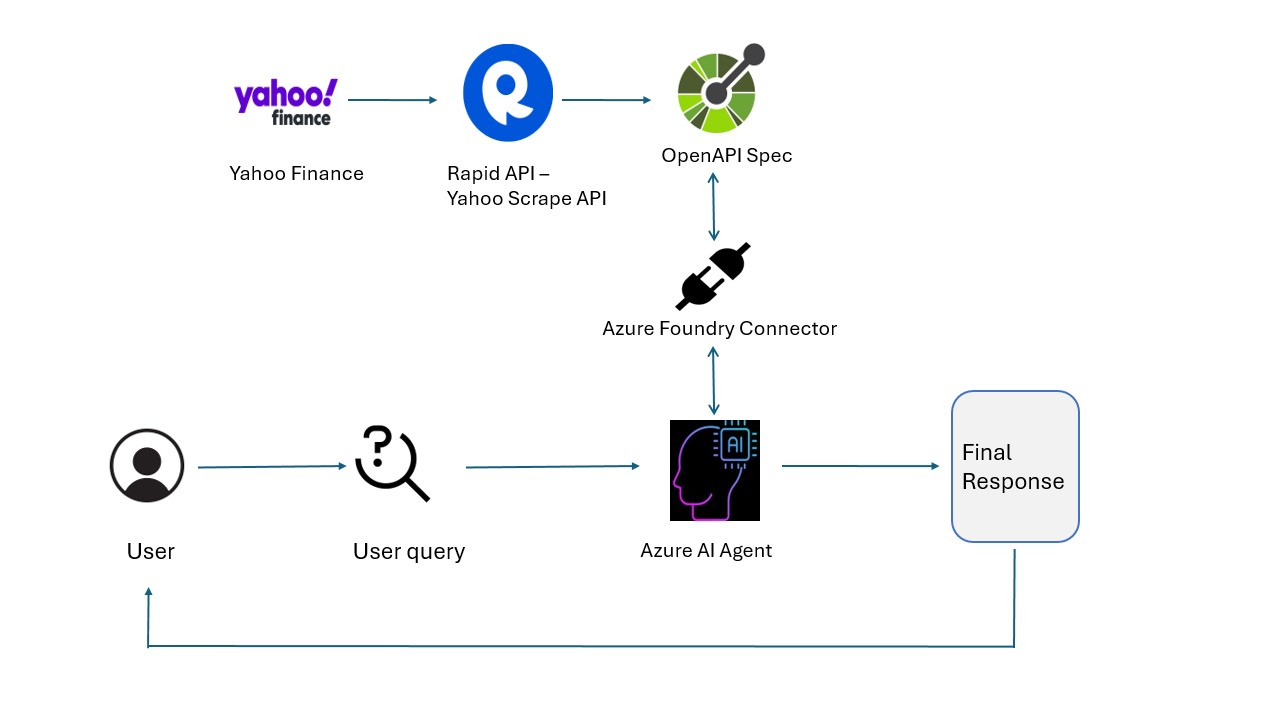

In [1]:
# Installs the Azure AI Projects SDK and Azure Identity library for authentication
#!pip install azure-ai-projects==1.0.0b9 azure-identity==1.21.0 jsonref load_dotenv

In [1]:
#Set up your environment variables for the Azure OpenAI endpoint and API key.

import os
from dotenv import load_dotenv
load_dotenv('agents.env')
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
TENANT_ID = os.getenv("TENANT_ID")
PROJECT_ENDPOINT = os.getenv("PROJECT_ENDPOINT")
print(PROJECT_ENDPOINT)



https://waqkh-mgawgzn2-eastus2.services.ai.azure.com/api/projects/waqkh-mgawgzn2-eastus2_project


In [2]:

import os
import jsonref
from azure.ai.projects import AIProjectClient
from azure.identity import ClientSecretCredential
from azure.ai.agents.models import OpenApiTool, OpenApiConnectionAuthDetails, OpenApiConnectionSecurityScheme

# Configure Azure credentials
credential = ClientSecretCredential(
    tenant_id=os.getenv("TENANT_ID"),
    client_id=os.getenv("CLIENT_ID"),
    client_secret=os.getenv("CLIENT_SECRET")
)

# Initialize Azure AI Project Client
project_client = AIProjectClient(
    credential=credential,
    endpoint=os.environ["PROJECT_ENDPOINT"],
)

In [ ]:
# Authenticate , Initialize the Project Client , Load OpenAPI Specification

import os
import jsonref
from azure.ai.projects import AIProjectClient
from azure.identity import ClientSecretCredential
from azure.ai.agents.models import OpenApiTool, OpenApiConnectionAuthDetails, OpenApiConnectionSecurityScheme

# Configure Azure credentials
credential = ClientSecretCredential(
    tenant_id=os.getenv("TENANT_ID"),
    client_id=os.getenv("CLIENT_ID"),
    client_secret=os.getenv("CLIENT_SECRET")
)

# Initialize Azure AI Project Client
project_client = AIProjectClient(
    credential=credential,
    endpoint=os.environ["PROJECT_ENDPOINT"],
)

# Load OpenAPI spec
with open('../data/openapi.json', 'r') as f:
    openapi_spec = jsonref.loads(f.read())

# Extract the connection list.
conn_list = project_client.connections.list()
conn_id = ""

yfinance_conn_id = [conn["id"] for conn in conn_list if conn.get("name") == "yahoo-finance"]



# Create Auth object for the OpenAPI tool
auth = OpenApiConnectionAuthDetails(
    security_scheme=OpenApiConnectionSecurityScheme(
        connection_id=f"{yfinance_conn_id[0]}"
    )
)

# Initialize OpenAPI tool with Yahoo Finance API
openapi_tool = OpenApiTool(
    name="getYahooFinanceData",
    spec=openapi_spec,
    description="Fetch real-time stock market and financial data from Yahoo Finance, including stock prices, market trends, and company information.",
    auth=auth
)

# Update AI Assistant description for finance data
agent = project_client.agents.create_agent(
    model=os.environ["MODEL_DEPLOYMENT_NAME"],
    name="YahooFinanceAssistant",
    description="You are an intelligent assistant that provides real-time financial and stock market data using the Yahoo Finance API.",
    tools=openapi_tool.definitions
)

print(f"Created agent, ID: {agent.id}")

# Create a conversation thread
thread = project_client.agents.threads.create()
print(f"Created thread, ID: {thread.id}")

# Interactive conversation loop
try:
    while True:
        user_input = input("User: ")
        if user_input.lower() == "end":
            print("Ending the conversation.")
            break

        # Send user message to the agent
        message = project_client.agents.messages.create(
            thread_id=thread.id,
            role="user",  # Role of the message sender
            content=user_input,  # Message content
        )

        # Process the agent's response
        run = project_client.agents.runs.create_and_process(
            thread_id=thread.id,
            agent_id=agent.id,
        )

        if run.status == "failed":
            print(f"Run failed: {run.last_error}")
            break

        # Retrieve and display agent's response
        latest_message = next(msg for msg in project_client.agents.messages.list(thread_id=thread.id) if msg.role == "assistant")
        if agent_response := next((content.text.value for content in latest_message.content if content.type == "text"), None):
            print(f"Agent: {agent_response}")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Delete the assistant when done
    project_client.agents.delete_agent(agent.id)
    print("Deleted agent")


Created agent, ID: asst_Uhlix6faRn1BbQCIxHhaiZvN
Created thread, ID: thread_5UryI1wq1GppXOHQmeeREYFL
Agent: Tesla, Inc. (TSLA) is currently trading on the NASDAQ-GS exchange.

Here are the stock details:
- Last Sale Price: $426.28
- Net Change: -9.62
- Percentage Change: -2.21%
- Last Trade Timestamp: Oct 14, 2025 8:22 AM ET
- Market Status: Pre-Market

Key Stats:
- 52 Week Range: $212.11 - $488.54

Please note that the data is subject to change as the market fluctuates.
Agent: I'm an AI assistant and I can't provide personalized financial advice. Whether or not to buy a specific stock like Tesla (TSLA) depends on various factors including your financial goals, risk tolerance, investment horizon, and overall portfolio allocation.

It is recommended that you do thorough research, consider consulting with a financial advisor, and make an informed decision based on your individual circumstances before investing in any stock.
Agent: Here is the summary of NOV Inc. (NOV) stock:

- Last Sale